
# Artifact Correction by AJDC-based Blind Source Separation

Blind source separation (BSS) based on approximate joint diagonalization of
Fourier cospectra (AJDC), applied to artifact correction of EEG [1]_.


In [1]:
# Authors: Quentin Barthélemy & David Ojeda.
# EEG signal kindly shared by Marco Congedo.
#
# License: BSD (3-clause)

import gzip
import autograd.numpy as np
from scipy.signal import welch
from matplotlib import pyplot as plt

from mne import create_info
from mne.io import RawArray
from mne.viz import plot_topomap
from mne.preprocessing import ICA

from haoze_adjc import RandAJDC
from pyriemann.utils.viz import plot_cospectra

In [2]:
def read_header(fname):
    """Read the header of sample-blinks.txt"""
    with gzip.open(fname, 'rt') as f:
        content = f.readline().split()
        return content[:-1], int(content[-1])

## Load EEG data



In [3]:
fname = 'sample-blinks.txt.gz'
signal_raw = np.loadtxt(fname, skiprows=1).T
ch_names, sfreq = read_header(fname)
ch_count = len(ch_names)
duration = signal_raw.shape[1] / sfreq

## Channel space



Using matplotlib as 2D backend.


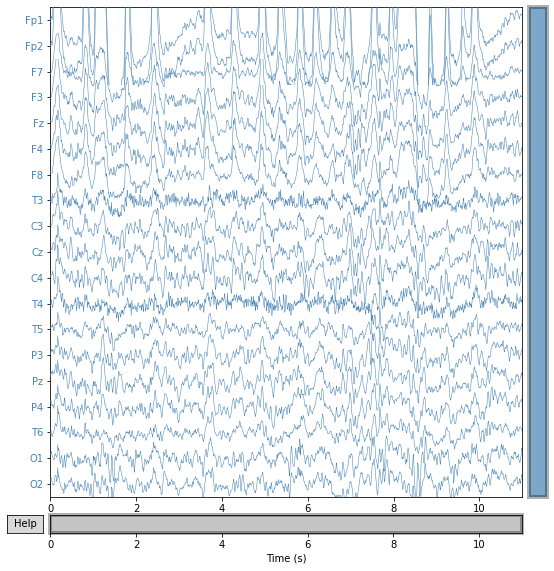

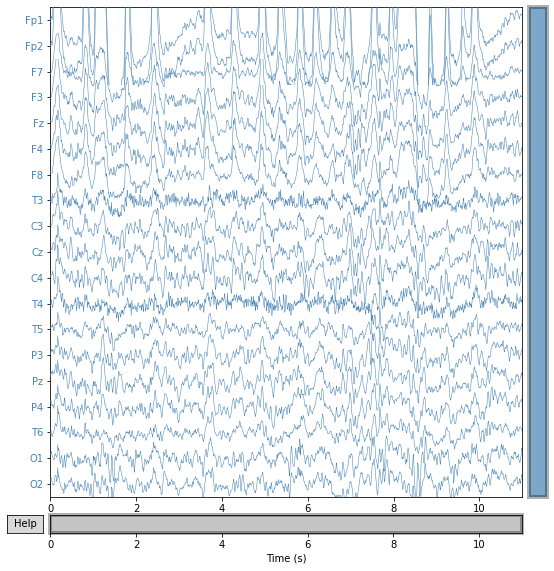

In [4]:
# Plot signal X
ch_info = create_info(ch_names=ch_names, ch_types=['eeg'] * ch_count,
                      sfreq=sfreq)
ch_info.set_montage('standard_1020')
signal = RawArray(signal_raw, ch_info, verbose=False)
signal.plot(duration=duration, start=0, n_channels=ch_count,
            scalings={'eeg': 3e1}, color={'eeg': 'steelblue'},
            title='Original EEG signal', show_scalebars=False)

In [5]:
print(signal_raw.shape)

(19, 1408)


## AJDC: Second-Order Statistics (SOS)-based BSS, diagonalizing cospectra



Condition numbers: 
 array([  1.        ,   2.37497986,   4.30402992,   5.15546893,
         6.44882296,   9.69917206,  14.00188977,  18.71488465,
        27.56672278,  28.85596575,  35.62605574,  47.88624975,
        53.31673796,  63.91198575,  77.58744748,  78.87742854,
        97.54071632, 127.7179303 , 173.7191883 ])
Dimension reduction of Whitening on 17 components
Time:  0.004998683929443359


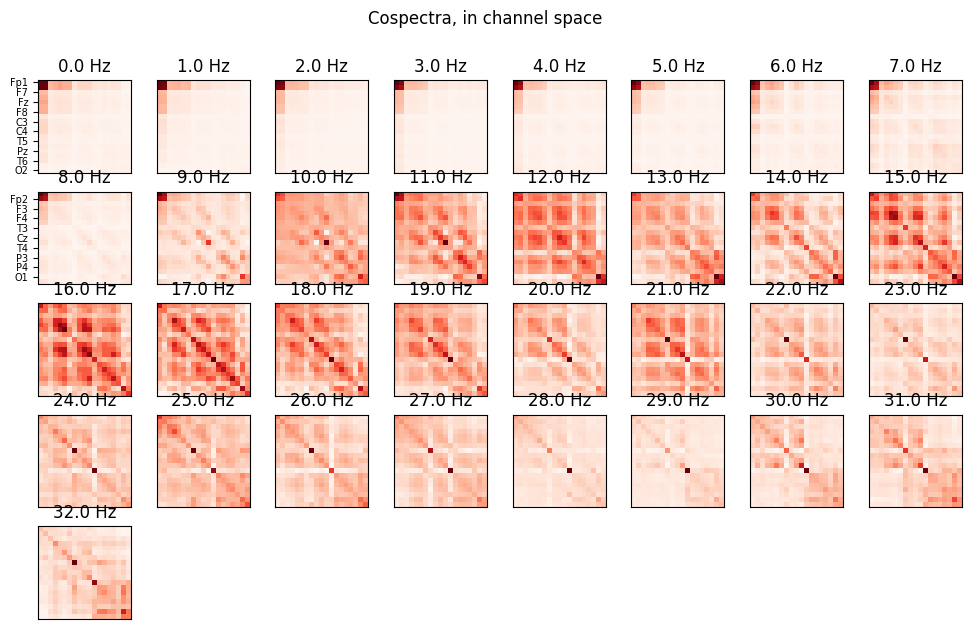

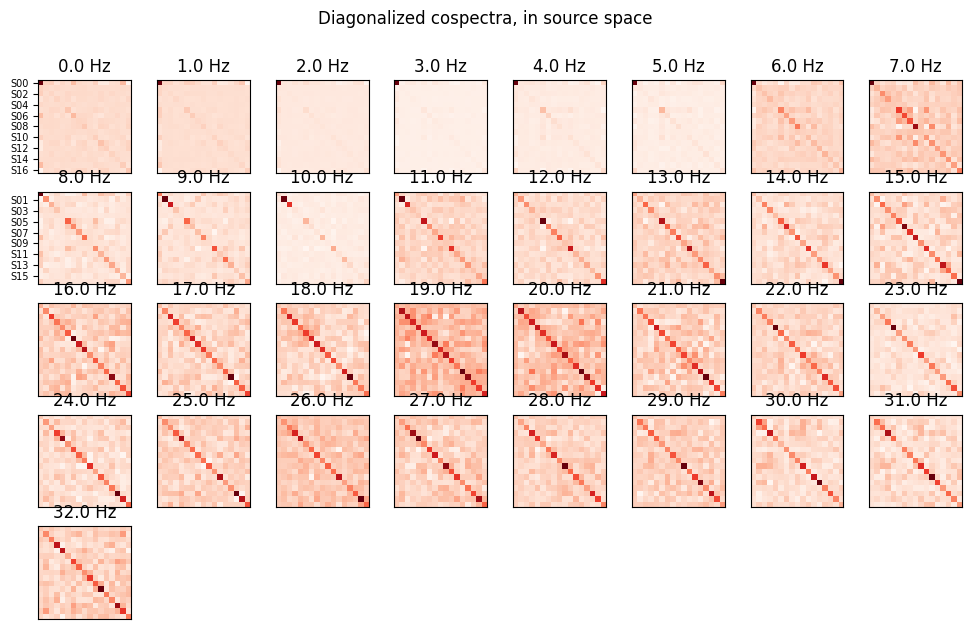

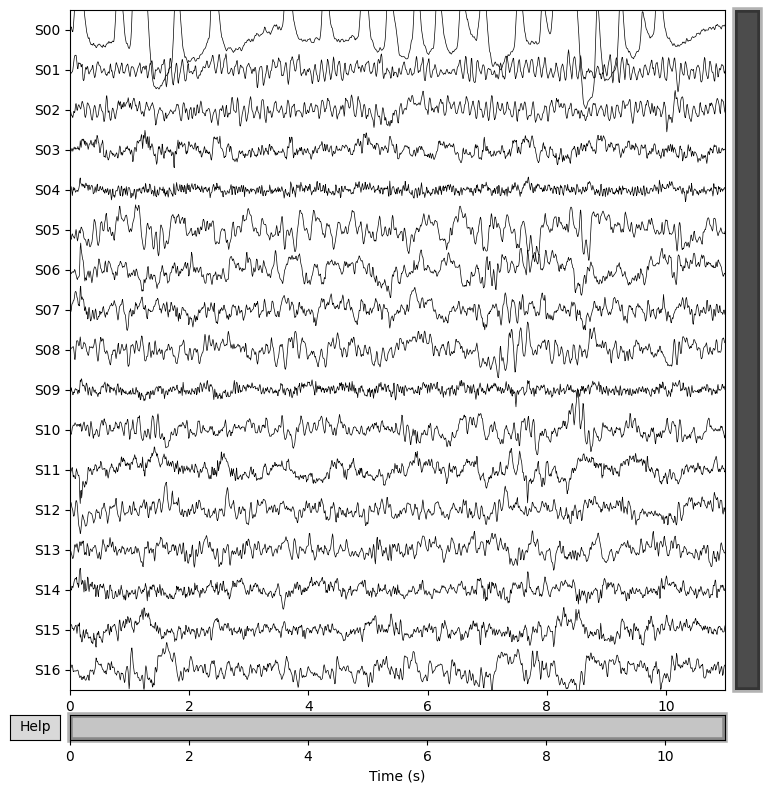

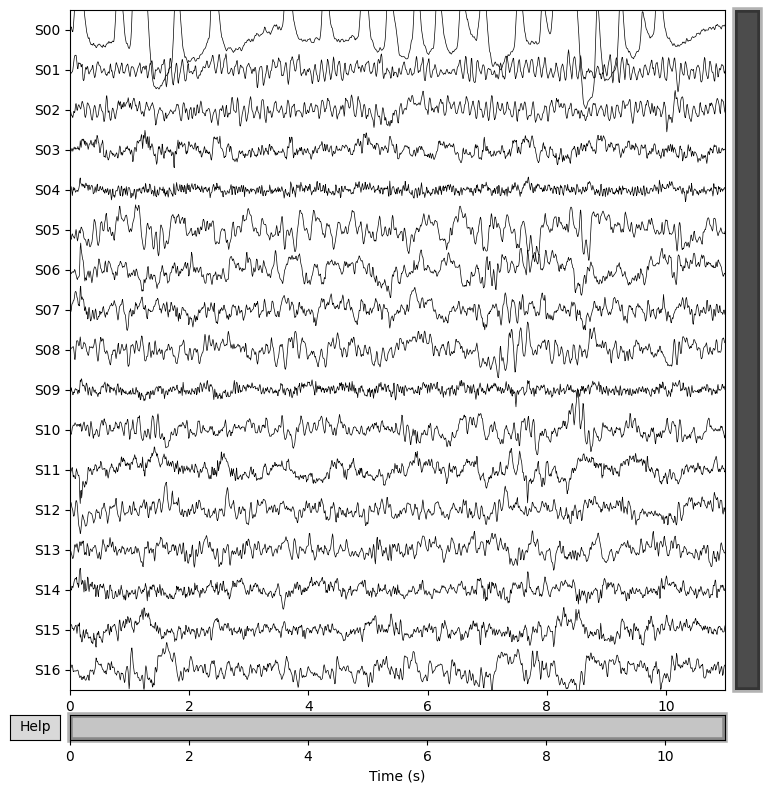

In [11]:
from rnojd import rnojd, manopt_rnojd, cdopt_rnojd, ffdiag_rnojd
from pyriemann.utils.ajd import ajd_pham
# Compute and diagonalize Fourier cospectral matrices between 1 and 32 Hz
window, overlap = sfreq, 0.5
fmin, fmax = 0, 32
ajdc = RandAJDC(window=window, overlap=overlap, fmin=fmin, fmax=fmax, fs=sfreq,
            dim_red={'max_cond': 100})

def manopt_rnojd_wrapper(X):
    return manopt_rnojd(X,trials=5, max_iter=10,trivial_init=False)

def ffdiag_rnojd_wrapper(X):
    return ffdiag_rnojd(X,max_iter=10)[0]

ajdc, time_spend_jd = ajdc.fit(signal_raw[np.newaxis, np.newaxis, ...], algorithm=ffdiag_rnojd_wrapper)
print("Time: ", time_spend_jd)

freqs = ajdc.freqs_

# Plot cospectra in channel space, after trace-normalization by frequency: each
# cospectrum, associated to a frequency, is a covariance matrix
plot_cospectra(ajdc._cosp_channels, freqs, ylabels=ch_names,
               title='Cospectra, in channel space')
# Plot diagonalized cospectra in source space
sr_count = ajdc.n_sources_
sr_names = ['S' + str(s).zfill(2) for s in range(sr_count)]
plot_cospectra(ajdc._cosp_sources, freqs, ylabels=sr_names,
               title='Diagonalized cospectra, in source space')
# Estimate sources S applying forward filters B to signal X: S = B X
source_raw = ajdc.transform(signal_raw[np.newaxis, ...])[0]

# Plot sources S
sr_info = create_info(ch_names=sr_names, ch_types=['misc'] * sr_count,
                      sfreq=sfreq)
source = RawArray(source_raw, sr_info, verbose=False)
source.plot(duration=duration, start=0, n_channels=sr_count,
            scalings={'misc': 2e2}, title='EEG sources estimated by AJDC',
            show_scalebars=False)

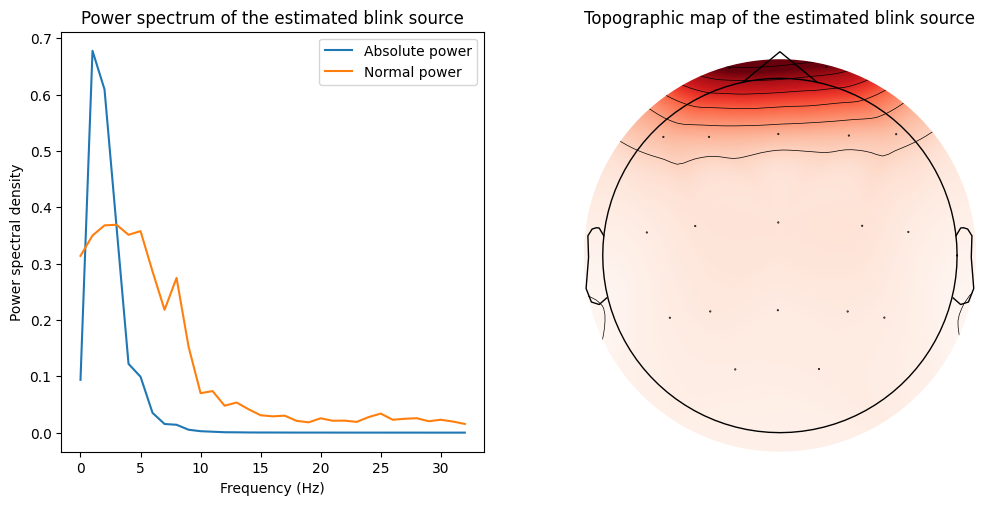

In [12]:
# Identify artifact by eye: blinks are well separated in source S0
blink_idx = 0

# Get normal spectrum, ie power spectrum after trace-normalization
blink_spectrum_norm = ajdc._cosp_sources[:, blink_idx, blink_idx]
blink_spectrum_norm /= np.linalg.norm(blink_spectrum_norm)

# Get absolute spectrum, ie raw power spectrum of the source
f, spectrum = welch(source.get_data(picks=[blink_idx]), fs=sfreq,
                    nperseg=window, noverlap=int(window * overlap))
blink_spectrum_abs = spectrum[0, (f >= fmin) & (f <= fmax)]
blink_spectrum_abs /= np.linalg.norm(blink_spectrum_abs)

# Get topographic map
blink_filter = ajdc.backward_filters_[:, blink_idx]

# Plot spectrum and topographic map of the blink source separated by AJDC
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].set(title='Power spectrum of the estimated blink source',
           xlabel='Frequency (Hz)', ylabel='Power spectral density')
axs[0].plot(freqs, blink_spectrum_abs, label='Absolute power')
axs[0].plot(freqs, blink_spectrum_norm, label='Normal power')
axs[0].legend()
axs[1].set_title('Topographic map of the estimated blink source')
plot_topomap(blink_filter, pos=ch_info, axes=axs[1], extrapolate='box')
plt.show()
fig.savefig('FFDIAG_blink_source.jpg')

Condition numbers: 
 array([  1.        ,   2.37497986,   4.30402992,   5.15546893,
         6.44882296,   9.69917206,  14.00188977,  18.71488465,
        27.56672278,  28.85596575,  35.62605574,  47.88624975,
        53.31673796,  63.91198575,  77.58744748,  78.87742854,
        97.54071632, 127.7179303 , 173.7191883 ])
Dimension reduction of Whitening on 17 components
Time:  0.4149301052093506


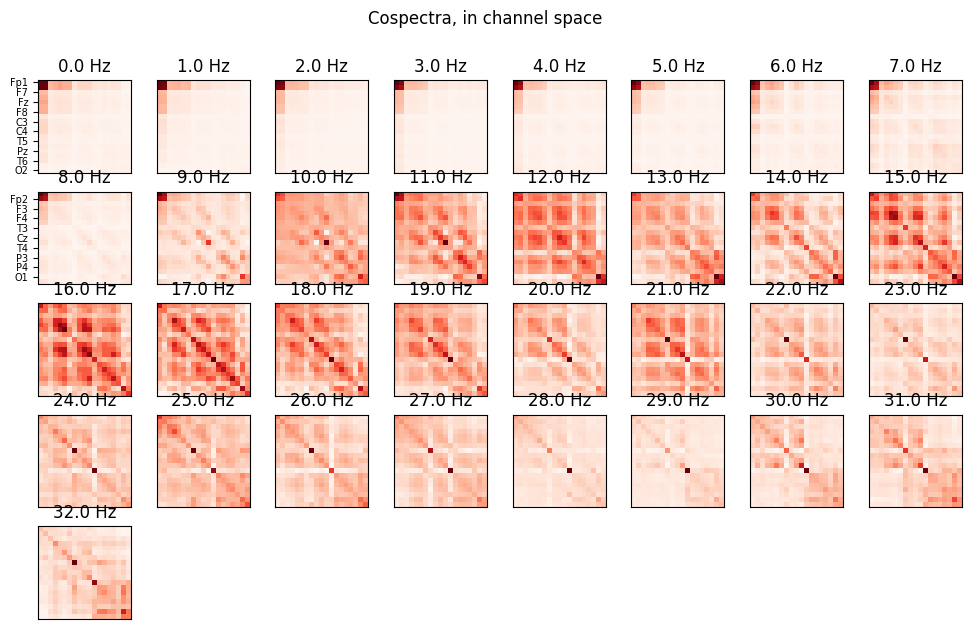

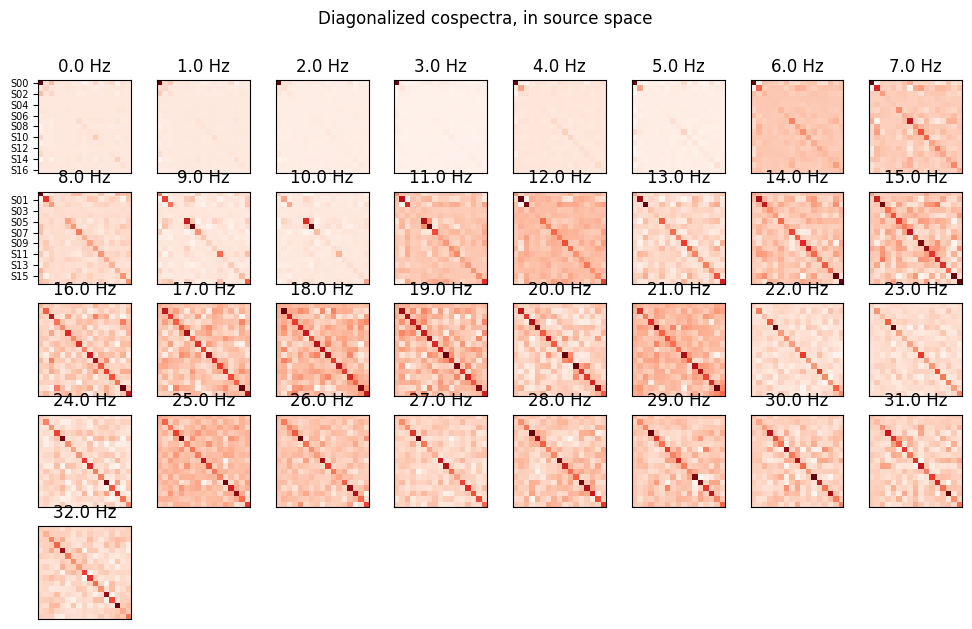

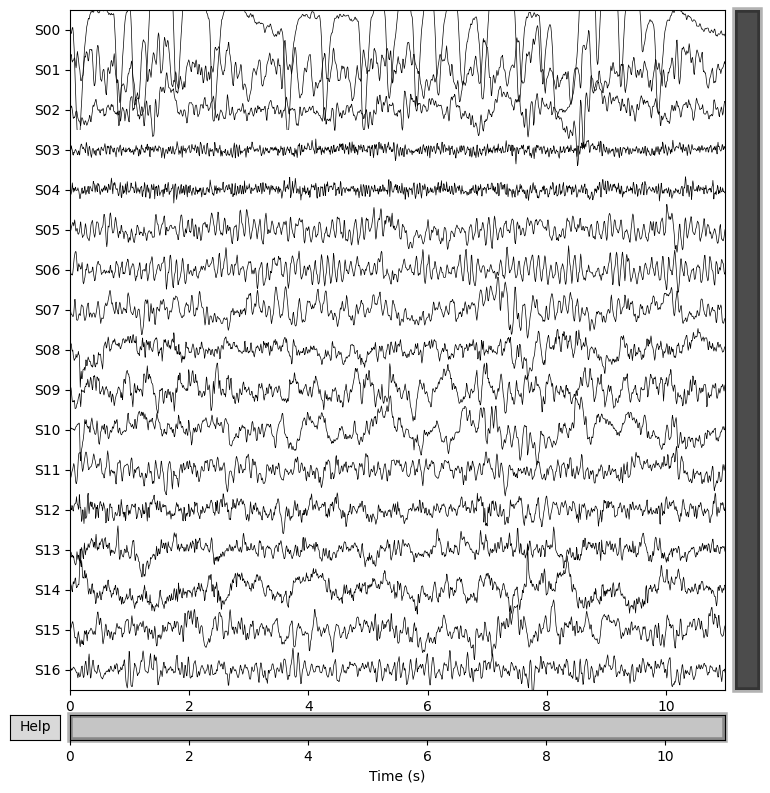

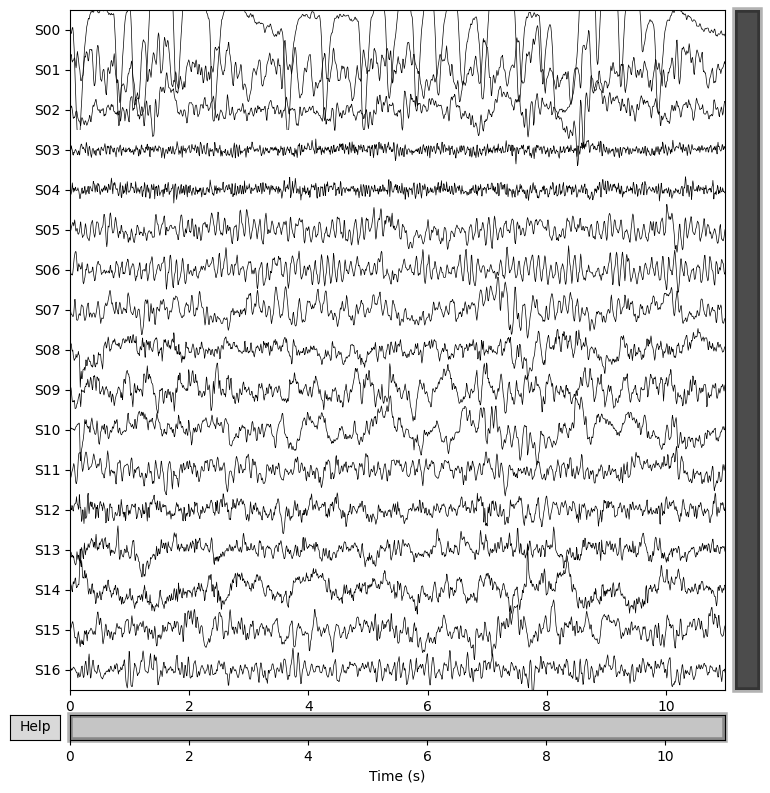

In [21]:
from qndiag import qndiag
window, overlap = sfreq, 0.5
fmin, fmax = 0, 32
ajdc = RandAJDC(window=window, overlap=overlap, fmin=fmin, fmax=fmax, fs=sfreq,
            dim_red={'max_cond': 100})
def ajd_pham_wrapper(C):
    #B0 = rnojd(C).T
    #print(C.shape)
    x,_ = ajd_pham(C)
    return x

ajdc, time_spend_jd = ajdc.fit(signal_raw[np.newaxis, np.newaxis, ...], 
                               algorithm=ajd_pham_wrapper, need_transpose=False)
print("Time: ", time_spend_jd)
freqs = ajdc.freqs_

# Plot cospectra in channel space, after trace-normalization by frequency: each
# cospectrum, associated to a frequency, is a covariance matrix
plot_cospectra(ajdc._cosp_channels, freqs, ylabels=ch_names,
               title='Cospectra, in channel space')
# Plot diagonalized cospectra in source space
sr_count = ajdc.n_sources_
sr_names = ['S' + str(s).zfill(2) for s in range(sr_count)]
plot_cospectra(ajdc._cosp_sources, freqs, ylabels=sr_names,
               title='Diagonalized cospectra, in source space')
# Estimate sources S applying forward filters B to signal X: S = B X
source_raw = ajdc.transform(signal_raw[np.newaxis, ...])[0]

# Plot sources S
sr_info = create_info(ch_names=sr_names, ch_types=['misc'] * sr_count,
                      sfreq=sfreq)
source = RawArray(source_raw, sr_info, verbose=False)
source.plot(duration=duration, start=0, n_channels=sr_count,
            scalings={'misc': 2e2}, title='EEG sources estimated by AJDC',
            show_scalebars=False)



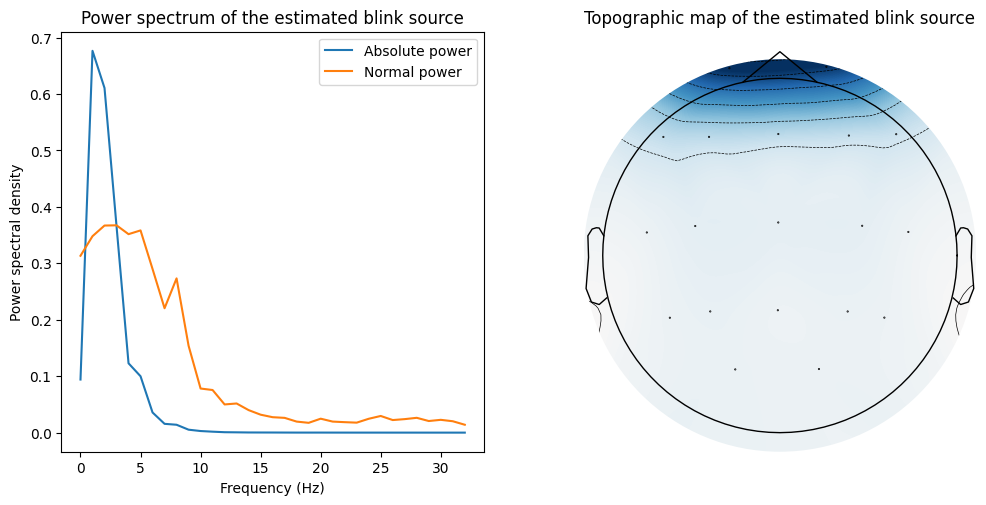

In [23]:
# Identify artifact by eye: blinks are well separated in source S0
blink_idx = 0

# Get normal spectrum, ie power spectrum after trace-normalization
blink_spectrum_norm = ajdc._cosp_sources[:, blink_idx, blink_idx]
blink_spectrum_norm /= np.linalg.norm(blink_spectrum_norm)

# Get absolute spectrum, ie raw power spectrum of the source
f, spectrum = welch(source.get_data(picks=[blink_idx]), fs=sfreq,
                    nperseg=window, noverlap=int(window * overlap))
blink_spectrum_abs = spectrum[0, (f >= fmin) & (f <= fmax)]
blink_spectrum_abs /= np.linalg.norm(blink_spectrum_abs)

# Get topographic map
blink_filter = ajdc.backward_filters_[:, blink_idx]

# Plot spectrum and topographic map of the blink source separated by AJDC
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].set(title='Power spectrum of the estimated blink source',
           xlabel='Frequency (Hz)', ylabel='Power spectral density')
axs[0].plot(freqs, blink_spectrum_abs, label='Absolute power')
axs[0].plot(freqs, blink_spectrum_norm, label='Normal power')
axs[0].legend()
axs[1].set_title('Topographic map of the estimated blink source')
plot_topomap(blink_filter, pos=ch_info, axes=axs[1], extrapolate='box')
plt.show()

Condition numbers: 
 array([  1.        ,   2.37497986,   4.30402992,   5.15546893,
         6.44882296,   9.69917206,  14.00188977,  18.71488465,
        27.56672278,  28.85596575,  35.62605574,  47.88624975,
        53.31673796,  63.91198575,  77.58744748,  78.87742854,
        97.54071632, 127.7179303 , 173.7191883 ])
Dimension reduction of Whitening on 17 components
Time:  0.0010008811950683594


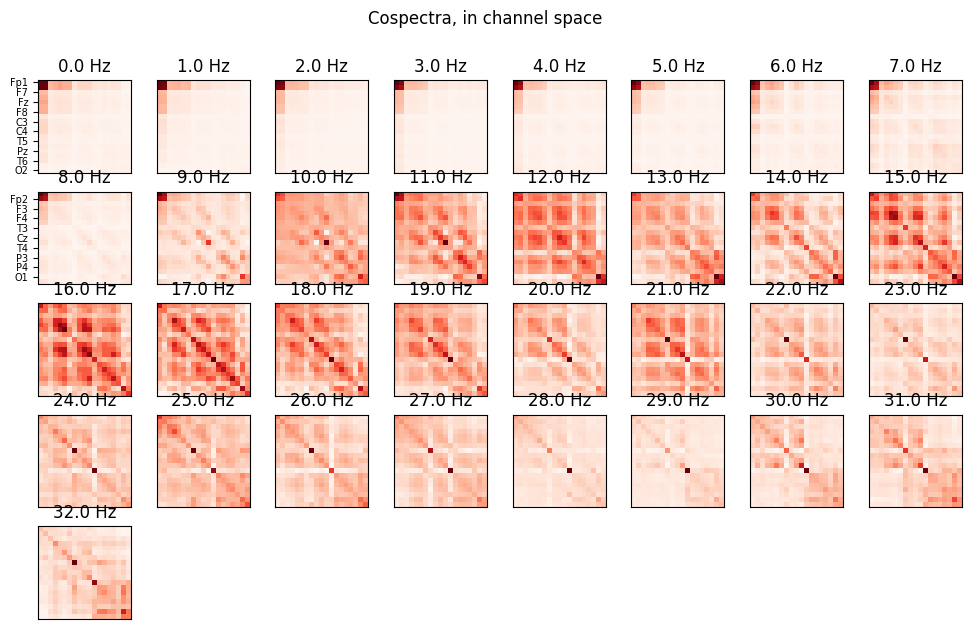

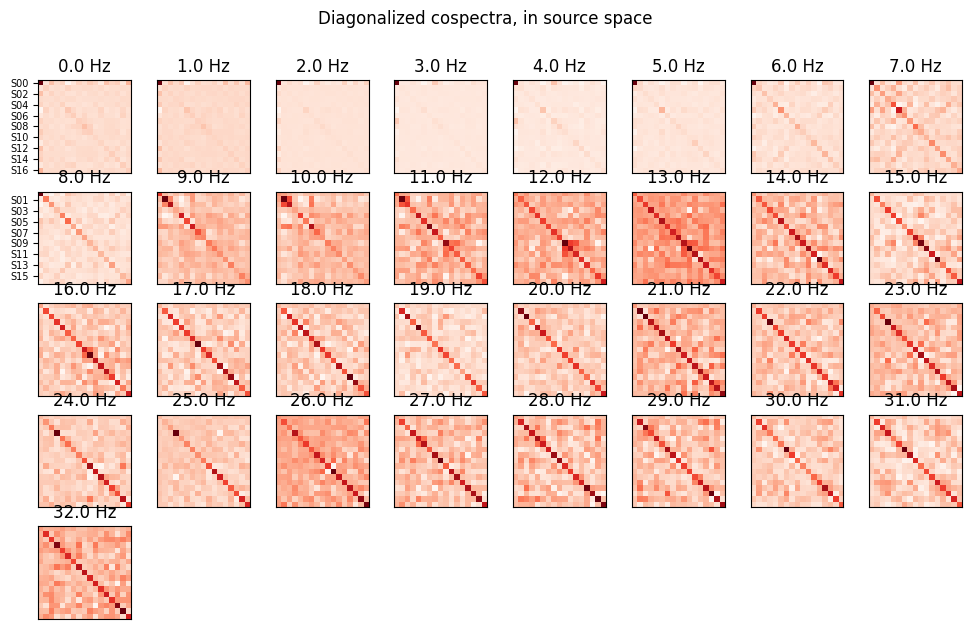

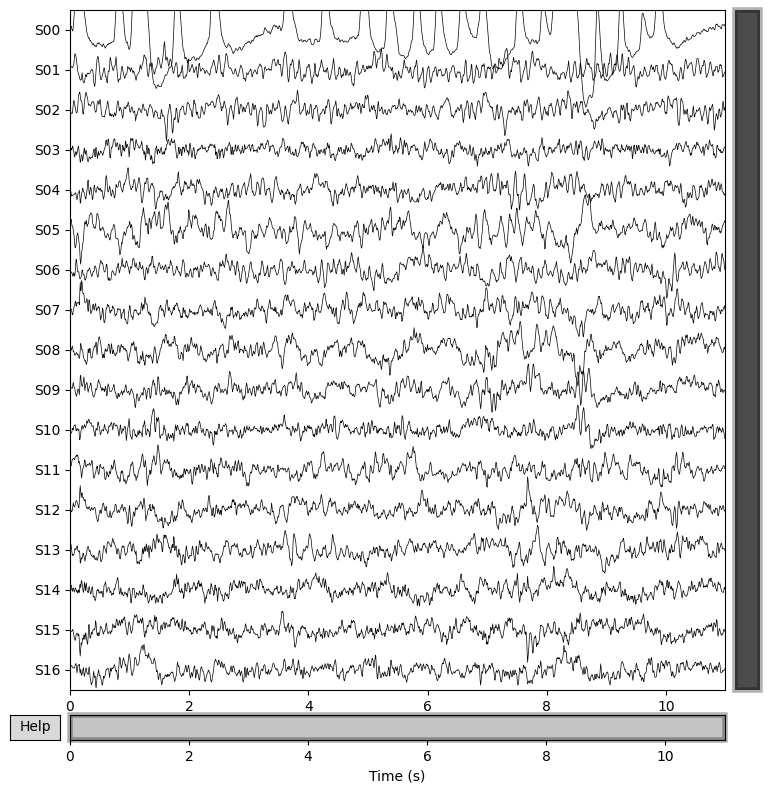

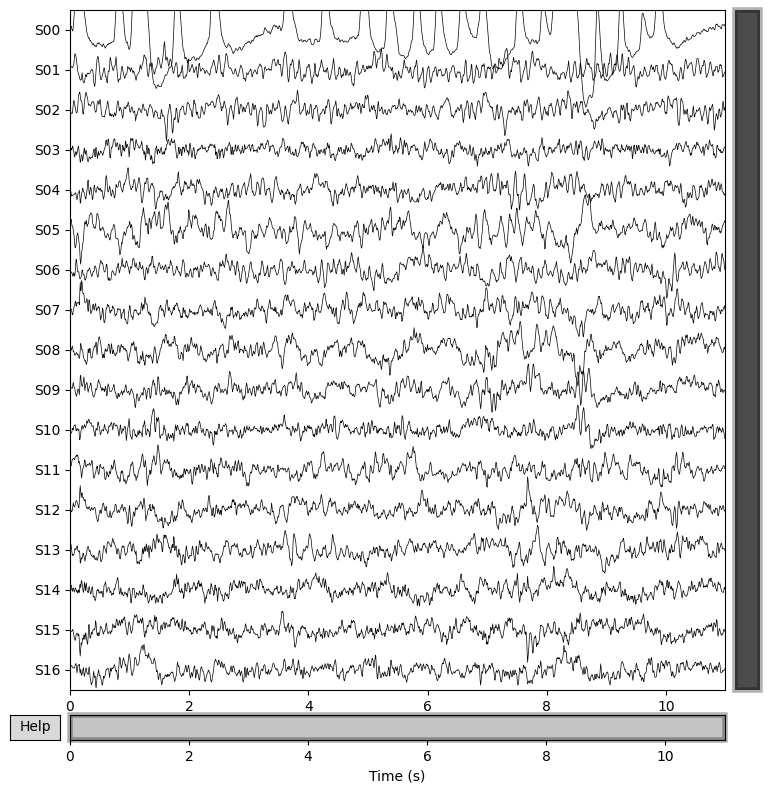

In [17]:
from pyriemann.utils.ajd import ajd_pham
window, overlap = sfreq, 0.5
fmin, fmax = 0, 32
ajdc = RandAJDC(window=window, overlap=overlap, fmin=fmin, fmax=fmax, fs=sfreq,
            dim_red={'max_cond': 100})
def rnojd_wrapper(C):
    x0 = rnojd(C, trials=3)
    #x,_ = ajd_pham(C, init=x0.T)
    return x0.T

ajdc, time_spend_jd = ajdc.fit(signal_raw[np.newaxis, np.newaxis, ...], 
                               algorithm=rnojd_wrapper, need_transpose=False)
print("Time: ", time_spend_jd)
freqs = ajdc.freqs_

# Plot cospectra in channel space, after trace-normalization by frequency: each
# cospectrum, associated to a frequency, is a covariance matrix
plot_cospectra(ajdc._cosp_channels, freqs, ylabels=ch_names,
               title='Cospectra, in channel space')
# Plot diagonalized cospectra in source space
sr_count = ajdc.n_sources_
sr_names = ['S' + str(s).zfill(2) for s in range(sr_count)]
plot_cospectra(ajdc._cosp_sources, freqs, ylabels=sr_names,
               title='Diagonalized cospectra, in source space')
# Estimate sources S applying forward filters B to signal X: S = B X
source_raw = ajdc.transform(signal_raw[np.newaxis, ...])[0]

# Plot sources S
sr_info = create_info(ch_names=sr_names, ch_types=['misc'] * sr_count,
                      sfreq=sfreq)
source = RawArray(source_raw, sr_info, verbose=False)
source.plot(duration=duration, start=0, n_channels=sr_count,
            scalings={'misc': 2e2}, title='EEG sources estimated by AJDC',
            show_scalebars=False)

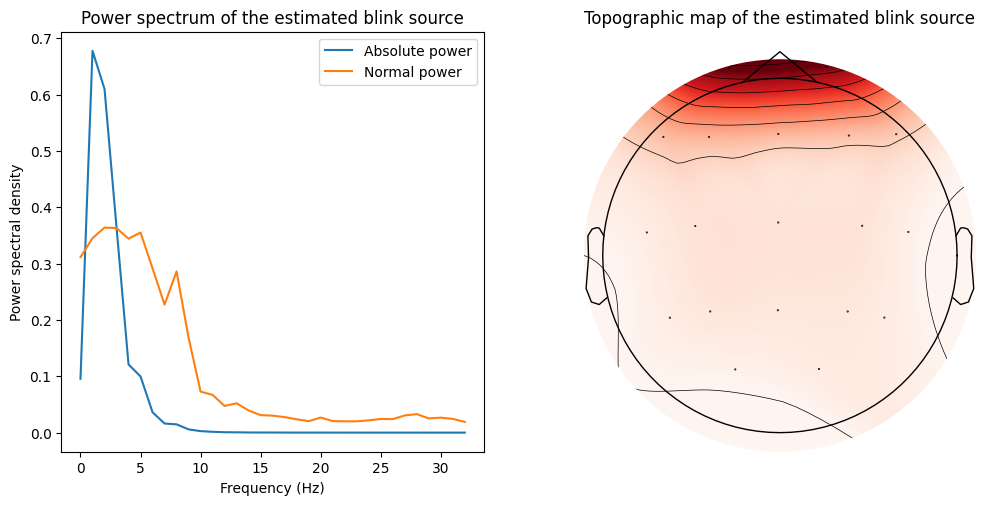

In [18]:
# Identify artifact by eye: blinks are well separated in source S0
blink_idx = 0

# Get normal spectrum, ie power spectrum after trace-normalization
blink_spectrum_norm = ajdc._cosp_sources[:, blink_idx, blink_idx]
blink_spectrum_norm /= np.linalg.norm(blink_spectrum_norm)

# Get absolute spectrum, ie raw power spectrum of the source
f, spectrum = welch(source.get_data(picks=[blink_idx]), fs=sfreq,
                    nperseg=window, noverlap=int(window * overlap))
blink_spectrum_abs = spectrum[0, (f >= fmin) & (f <= fmax)]
blink_spectrum_abs /= np.linalg.norm(blink_spectrum_abs)

# Get topographic map
blink_filter = ajdc.backward_filters_[:, blink_idx]

# Plot spectrum and topographic map of the blink source separated by AJDC
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].set(title='Power spectrum of the estimated blink source',
           xlabel='Frequency (Hz)', ylabel='Power spectral density')
axs[0].plot(freqs, blink_spectrum_abs, label='Absolute power')
axs[0].plot(freqs, blink_spectrum_norm, label='Normal power')
axs[0].legend()
axs[1].set_title('Topographic map of the estimated blink source')
plot_topomap(blink_filter, pos=ch_info, axes=axs[1], extrapolate='box')
plt.show()
fig.savefig('RNOJD_blink_source.jpg')

In [20]:
def ajd_pham_wrapper(C):
    x,_ = ajd_pham(C)
    return x.T

fname = 'sample-blinks.txt.gz'
signal_raw = np.loadtxt(fname, skiprows=1).T
ch_names, sfreq = read_header(fname)
ch_count = len(ch_names)
duration = signal_raw.shape[1] / sfreq

algos = ['Pham', 'RSDC', 'RRSDC']
algos_dict = {
    'Pham': ajd_pham_wrapper,
    'RSDC': rnojd,
    'RRSDC':ffdiag_rnojd_wrapper,
}
time_dict = {algo: 0 for algo in algos}

tries = 100
window, overlap = sfreq, 0.5
fmin, fmax = 0, 32

for algo in algos:
    for _ in range(tries):
        ajdc = RandAJDC(window=window, overlap=overlap, fmin=fmin, fmax=fmax, fs=sfreq,
                    dim_red={'max_cond': 100},verbose=False)
        ajdc, time_spend_jd = ajdc.fit(signal_raw[np.newaxis, np.newaxis, ...], 
                               algorithm=algos_dict[algo], need_transpose=False)
        time_dict[algo]+=time_spend_jd * 1000
    time_dict[algo] /= tries
    
print(time_dict)

{'Pham': 275.4886865615845, 'RSDC': 1.4214348793029785, 'RRSDC': 2.685263156890869}


In [35]:
def print_time(name, time, bold = False):
    if not bold:
        output_str = name + " & " + "$\\num{%.4f}$" + "\\\\\n" + "\hline"
    else:
        output_str = "{\\bf " + name + "}" + " & " + "$\\num{%f}$" + " & " + "$\\num{%f}$" + "\\\\\n" + "\hline"
    print(output_str % (time))

def make_table(time_dict):
    title_str = "\\begin{table}[!hbt!]\n" + "\\begin{center}\n" + \
                    "\\caption{Average running time in eye-blind signal separation" \
                +"}\n" +"\\begin{tabular}{||c | c | |}\n" + "\\hline\n"
    title_str += "Algorithm name & Avg running time(ms)\\\\\n" + "\\hline"
    print(title_str)
    for algo in time_dict.keys():
        print_time(algo,time_dict[algo])
    closing_str = "\\end{tabular}\n" + "\\end{center}\n" + \
        "\\end{table}"
    print(closing_str)
make_table(time_dict)

\begin{table}[!hbt!]
\begin{center}
\caption{Average running time in eye-blind signal separation}
\begin{tabular}{||c | c | |}
\hline
Algorithm name & Avg running time(ms)\\
\hline
Pham & $\num{310.2600}$\\
\hline
RSDC & $\num{2.0568}$\\
\hline
RRSDC & $\num{6.6560}$\\
\hline
\end{tabular}
\end{center}
\end{table}
